In [1]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from notebook_utils import get_distribution_over_vocabulary, get_mlm_results, get_downstream_results

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
FIGURE_DIR = "/home/limisiewicz/my-luster/entangled-in-scripts/output/figures"
TABLE_DIR =  "/home/limisiewicz/my-luster/entangled-in-scripts/output/tables"

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18


## Parameteres

In [6]:
languages = ("ar", "tr", "zh", "el", "es", "en", "sw", "hi", "mr", "ur", "ta", "te", "th", "ru", "bg", "he", "ka", "vi", "fr", "de")
alpha = 0.25
tokenization_types = ('20l-multilingual', '20l-merged', '20l-bpe')
N_vocab = 120000


ft_type = 'PROBE'

In [7]:
in_lang_results = pd.DataFrame(columns=['task', 'metric', 'tokenizer'] + list(languages) + ['multilingual'] )
in_lang_stds = pd.DataFrame(columns=['task', 'metric', 'tokenizer'] + list(languages) + ['multilingual'] )

# Tokenizers and Distributions over Vocabulary

In [8]:
vocab_distributions = {tok_type: get_distribution_over_vocabulary(tok_type, alpha, N_vocab, languages) for 
                      tok_type in tokenization_types}

## Probability Distribution Function
The tokens are sorted by frequency

In [9]:
def boxplot_across_languages(res, metric, languages, task=None):
    if task:
        metric_df = pd.melt(res[(res.metric == metric) & (res.task == task)], id_vars='tokenizer',
                     value_vars=languages, value_name=metric, var_name="language")
    else:
        metric_df = pd.melt(res[res.metric == metric], id_vars='tokenizer',
                     value_vars=languages, value_name=metric, var_name="language")
    sns.boxplot(data=metric_df, x=metric, y='tokenizer')

<Figure size 640x480 with 0 Axes>

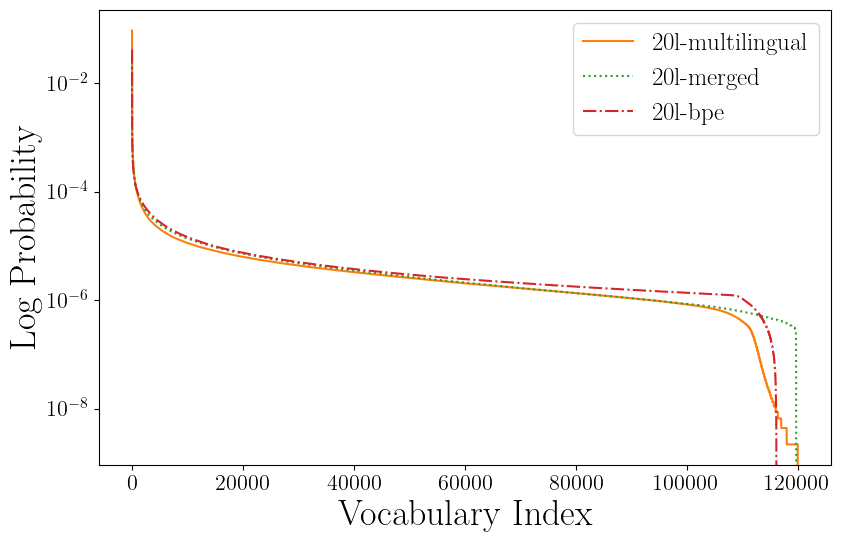

In [10]:
line_styles=['-', ':', '-.', '--']
colors= ["C1", "C2", "C3", "C4"]
plt.figure()
f, ax = plt.subplots(figsize=(9, 6))
for t_idx, tokenization in enumerate(tokenization_types):
    sorted_data = np.sort(vocab_distributions[tokenization]['multilingual'])[::-1]
    ax.plot(sorted_data,c=colors[t_idx],ls=line_styles[t_idx], label=tokenization)
ax.set_yscale('log')
ax.set_ylabel('Log Probability')
ax.set_xlabel('Vocabulary Index')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_log_pdf_20L.pdf"), dpi=300)
plt.show()

## Cumulative Distribution Function

<Figure size 640x480 with 0 Axes>

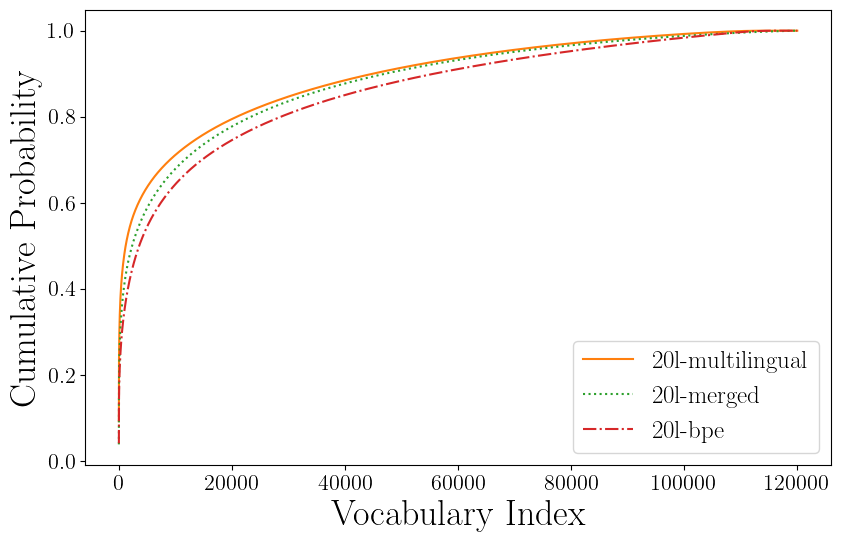

In [11]:
line_styles=['-', ':', '-.', '--']
colors= ["C1", "C2", "C3", "C4"]
plt.figure()
f, ax = plt.subplots(figsize=(9, 6))
for t_idx, tokenization in enumerate(tokenization_types):
    sorted_data = np.sort(vocab_distributions[tokenization]['multilingual'])[::-1]
    cdf = np.cumsum(sorted_data)
    ax.plot(cdf,c=colors[t_idx],ls=line_styles[t_idx], label=tokenization)

ax.set_ylabel('Cumulative Probability')
ax.set_xlabel('Vocabulary Index')
ax.legend()


plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_cdf_20L.pdf"), dpi=300)
plt.show()

## Cumulative Distribution Functions (for specific languages)

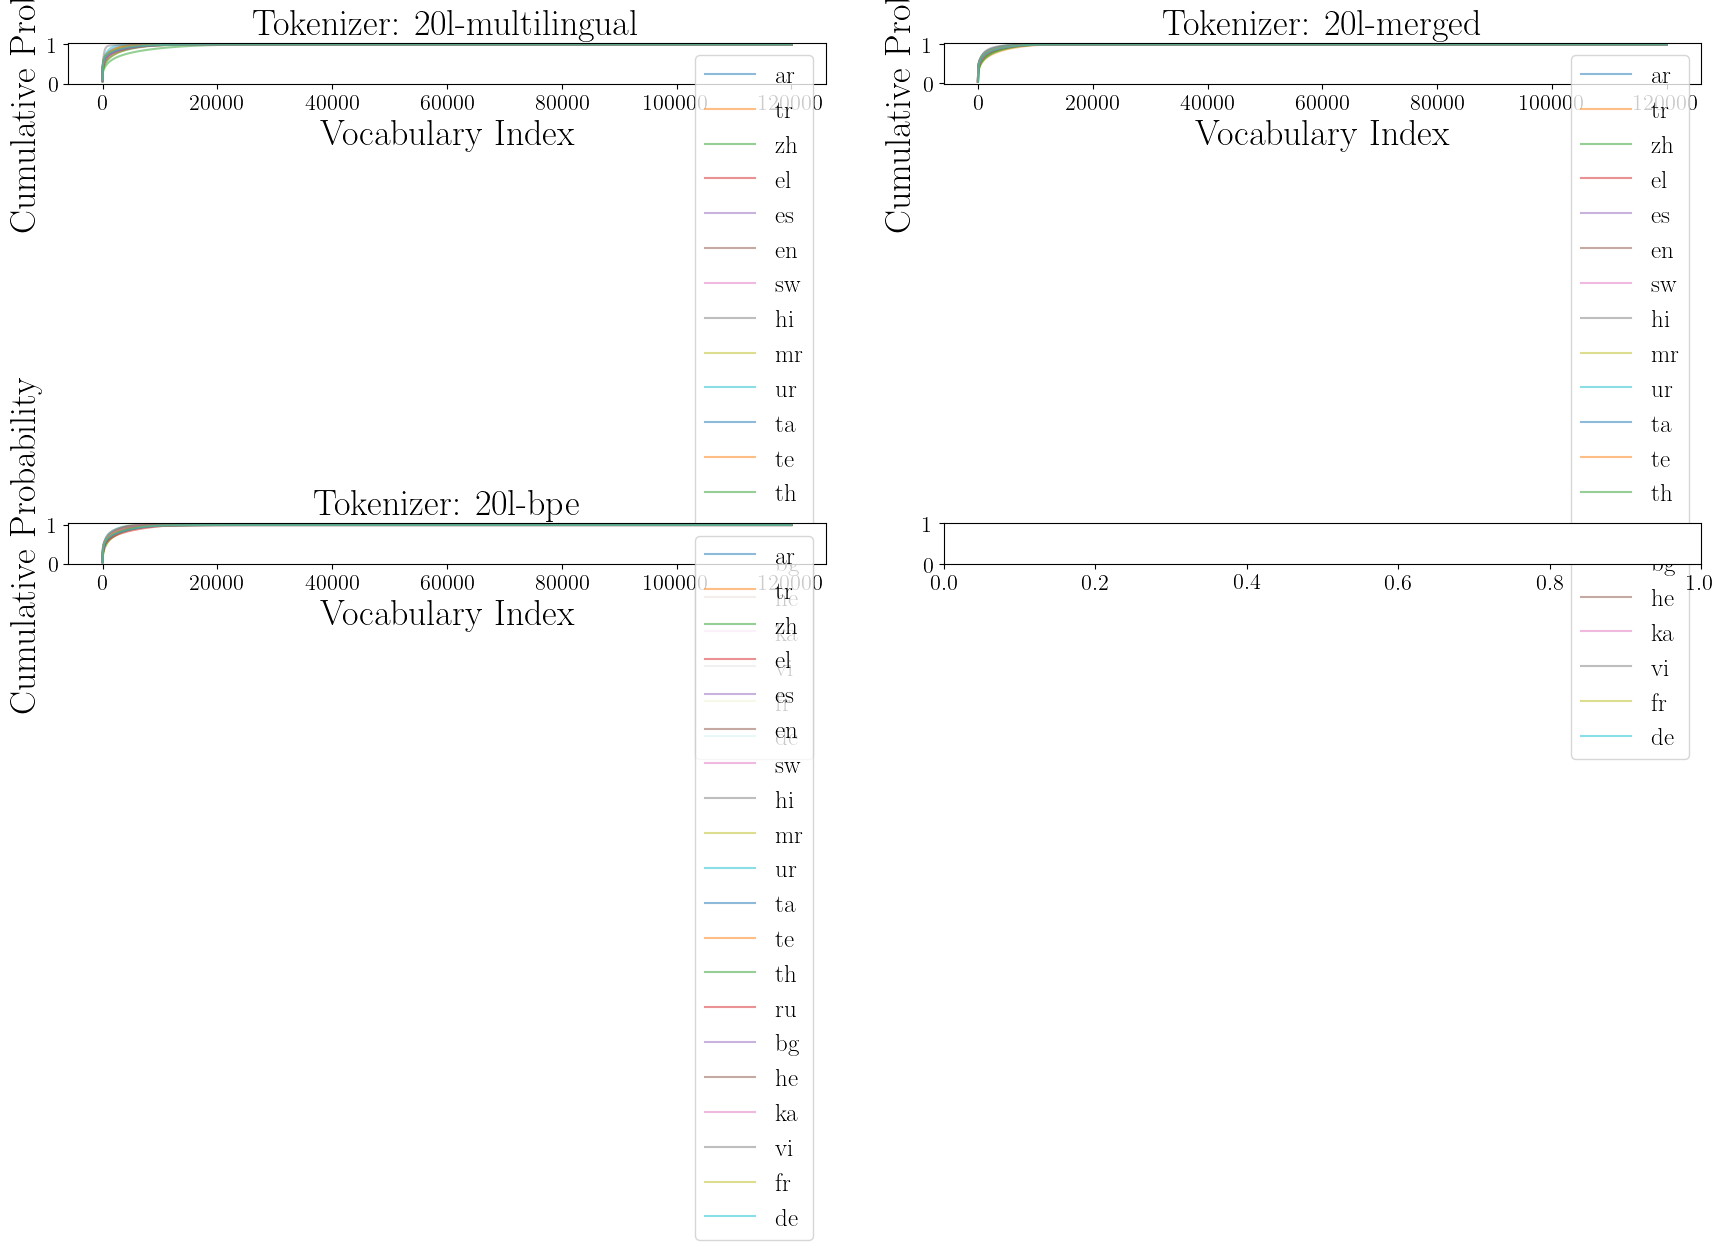

In [12]:
fig, axes = plt.subplots(2, 2,figsize=(18, 10))
axes = axes.ravel()
for t_idx, tokenization in enumerate(tokenization_types):
    ax = axes[t_idx]
    for lang in languages:
        sorted_lang_data = np.sort(vocab_distributions[tokenization][lang])[::-1]
        axes[t_idx].plot(np.cumsum(sorted_lang_data), label=lang, alpha=0.5)
        axes[t_idx].set_ylabel('Cumulative Probability')
        axes[t_idx].set_xlabel('Vocabulary Index')
        axes[t_idx].legend()
    axes[t_idx].set_title(f"Tokenizer: {tokenization}")
    axes[t_idx].legend()

    
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_cdf_each_language_20L.pdf"), dpi=300)
plt.show()

## Average Ranks of Vocabulary Units (Vocab allocation)

In [13]:
def compute_rank_average(probabilites):
    sorted_probabilities = np.sort(probabilites)[::-1]
    r_e = np.sum(sorted_probabilities * np.arange(len(probabilites)))
    return r_e

def compute_rank_std(probabilites):
    sorted_probabilities = np.sort(probabilites)[::-1]
    r_e = np.sum(sorted_probabilities * np.arange(len(probabilites)))
    r_e2 = np.sum(sorted_probabilities * (np.arange(len(probabilites)) ** 2.))
    
    return np.sqrt(r_e2 - (r_e ** 2.))
    

In [14]:
for tokenization in tokenization_types:
    rank_est = {'task': 'allocation', 'metric': 'Avg. Rank', 'tokenizer': tokenization} 
    rank_std = {'task': 'allocation', 'metric': 'Avg. Rank', 'tokenizer': tokenization} 

    for lang, probabilities in vocab_distributions[tokenization].items():
        rank_est[lang] = compute_rank_average(probabilities)
        rank_std[lang] = compute_rank_std(probabilities)

    in_lang_results = in_lang_results.append(rank_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(rank_std, ignore_index=True)

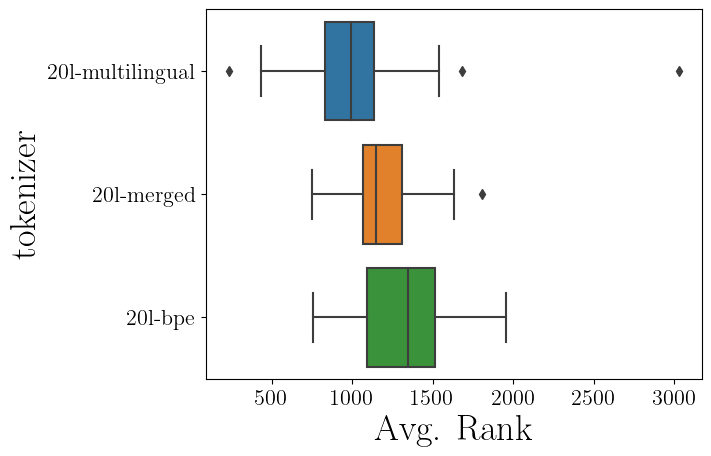

In [15]:
boxplot_across_languages(in_lang_results, 'Avg. Rank', languages)

# Results for LMs

## Original task performance (MRR / BPC)

In [16]:
mlm_results = {tok_type: get_mlm_results(tok_type, alpha, N_vocab, languages) for 
                      tok_type in tokenization_types}

Mean reciprocal rank

In [17]:


for tokenization in tokenization_types:
    mrr_est = {'task': 'LM', 'metric': 'MRR', 'tokenizer': tokenization} 
    mrr_std = {'task': 'LM', 'metric': 'MRR', 'tokenizer': tokenization} 
    
    mrr_est.update(mlm_results[tokenization]['mrr'])
    mrr_est['multilingual'] = np.average(list(mlm_results[tokenization]['mrr'].values()))
    
    for lang in languages:
        mrr_std[lang] = 0.
    mrr_std['multilingual'] = 0.

    in_lang_results = in_lang_results.append(mrr_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(mrr_std, ignore_index=True)

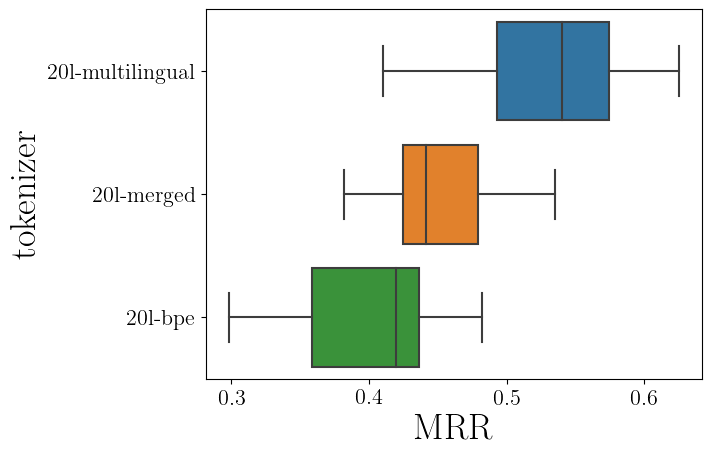

In [18]:
boxplot_across_languages(in_lang_results, 'MRR', languages)

Bits per character

In [19]:
for tokenization in tokenization_types:
    mrr_est = {'task': 'LM', 'metric': 'BPC', 'tokenizer': tokenization} 
    mrr_std = {'task': 'LM', 'metric': 'BPC', 'tokenizer': tokenization} 
    
    mrr_est.update(mlm_results[tokenization]['bpc'])
    mrr_est['multilingual'] = np.average(list(mlm_results[tokenization]['bpc'].values()))
    
    for lang in languages:
        mrr_std[lang] = 0.
    mrr_std['multilingual'] = 0.

    in_lang_results = in_lang_results.append(mrr_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(mrr_std, ignore_index=True)

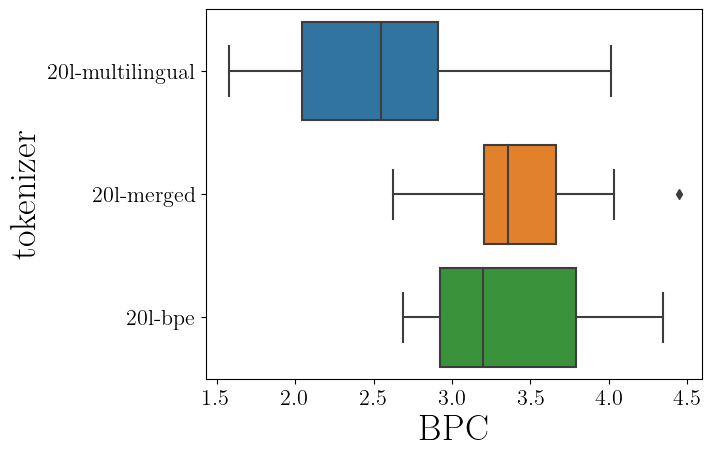

In [20]:
boxplot_across_languages(in_lang_results, 'BPC', languages)

## Down-stream task performance (POS / NER / ...)

POS

In [21]:
pos_results = dict()
pos_stds = dict()

metrics = ('accuracy','f1-macro')
for tok_type in tokenization_types:
    pos_results[tok_type], pos_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'POS', ft_type='FT', metrics=metrics)
    pos_results[tok_type] = {m : {lang: pos_results[tok_type][m][lang][lang] for lang in languages}
                             for m in metrics}
    pos_stds[tok_type] = {m: {lang: pos_stds[tok_type][m][lang][lang] for lang in languages}
                          for m in metrics}

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/ar/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/ar/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/ar/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/ar/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/ar/accuracy_evaluation/tr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/el/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/el/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/el/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/el/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/el/accuracy_evaluation/tr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/en/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/en/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/en/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/en/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/sw/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/ur/accuracy_evaluation/fr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/ur/accuracy_evaluation/fr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/ur/accuracy_evaluation/fr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/ur/accuracy_evaluation/fr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/ur/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/ru/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/ru/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/ru/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/ru/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/bg/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/vi/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/vi/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/vi/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/vi/accuracy_evaluation/de/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/fr/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/tr/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/tr/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/tr/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/tr/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/tr/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/es/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/es/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/es/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/es/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/es/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/mr/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/mr/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/mr/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/mr/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/mr/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/te/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/te/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/te/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/te/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/te/accuracy_evaluation/ta/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/he/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/he/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/he/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/he/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/he/accuracy_evaluation/ur/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/de/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/de/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/de/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/de/accuracy_evaluation/hi/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/de/accuracy_evaluation/mr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/tr/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/tr/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/tr/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/tr/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/tr/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/es/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/es/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/es/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/es/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/es/accuracy_evaluation/ka/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/mr/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/mr/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/mr/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/mr/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/mr/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/te/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/te/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/te/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/te/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/te/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/he/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/he/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/he/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/he/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/he/accuracy_evaluation/he/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/de/accuracy_evaluation/ru/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/de/accuracy_evaluation/ru/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/de/accuracy_evaluation/ru/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/de/accuracy_evaluation/ru/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/de/accuracy_evaluation/bg/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_FT/20l-bpe-tokenization/alpha-0.25_alpha

In [22]:
for tokenization in tokenization_types:
    pos_est = {'task': 'POS', 'metric': 'accuracy', 'tokenizer': tokenization} 
    pos_std = {'task': 'POS', 'metric': 'accuracy', 'tokenizer': tokenization} 
    
    pos_est.update(pos_results[tokenization]['accuracy'])
    pos_est['multilingual'] = np.average(list(pos_results[tokenization]['accuracy'].values()))
    
    pos_std.update(pos_stds[tokenization]['f1-macro'])
    pos_std['multilingual'] = np.average(list(pos_stds[tokenization]['accuracy'].values()))
    

    in_lang_results = in_lang_results.append(pos_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(pos_std, ignore_index=True)

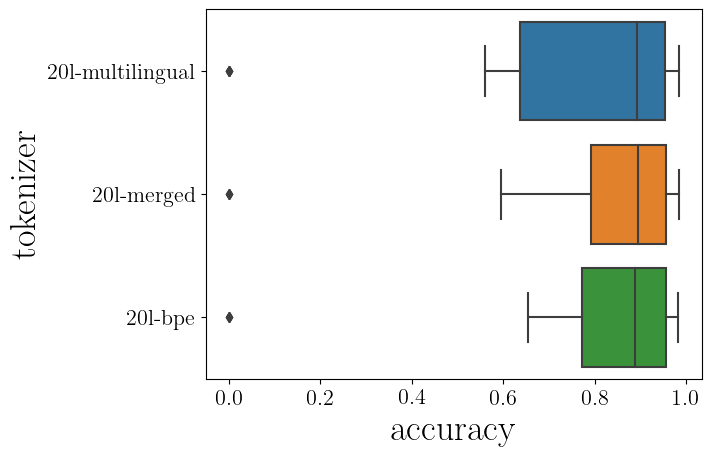

In [23]:
boxplot_across_languages(in_lang_results, 'accuracy', languages, task='POS')

NER

In [24]:
ner_results = dict()
ner_stds = dict()

metrics = ('f1-seqeval','f1-macro')
for tok_type in tokenization_types:
    ner_results[tok_type], ner_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'NER',ft_type='FT', metrics=metrics)
    ner_results[tok_type] = {m : {lang: ner_results[tok_type][m][lang][lang] for lang in languages}
                             for m in metrics}
    ner_stds[tok_type] = {m: {lang: ner_stds[tok_type][m][lang][lang] for lang in languages}
                          for m in metrics}

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1234/ar/f1-seqeval_evaluation/ar/f1-seqeval_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/ar/f1-seqeval_evaluation/ar/f1-seqeval_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/ar/f1-seqeval_evaluation/ar/f1-seqeval_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/ar/f1-seqeval_evaluation/ar/f1-seqeval_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/ar/f1-seqeval_evaluation/ar/f1-seqeval_all.txt not found.
/home/limisiewicz/my-luster/entangl

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/zh/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/zh/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/zh/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/zh/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/zh/f1-macro_evaluation/el/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/es/f1-macro_evaluation/de/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/es/f1-macro_evaluation/de/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/es/f1-macro_evaluation/de/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/es/f1-macro_evaluation/de/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/en/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/mr/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/mr/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/mr/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/mr/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/mr/f1-macro_evaluation/el/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/te/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/te/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/te/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/te/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/te/f1-macro_evaluation/en/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/bg/f1-macro_evaluation/mr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/bg/f1-macro_evaluation/mr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/bg/f1-macro_evaluation/mr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/bg/f1-macro_evaluation/mr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/bg/f1-macro_evaluation/ur/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/fr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/fr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/fr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/fr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/fr/f1-macro_evaluation/tr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/tr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/tr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/tr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/tr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/tr/f1-macro_evaluation/tr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/en/f1-macro_evaluation/ru/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/en/f1-macro_evaluation/ru/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/en/f1-macro_evaluation/ru/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/en/f1-macro_evaluation/ru/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/en/f1-macro_evaluation/bg/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/te/f1-macro_evaluation/ur/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/te/f1-macro_evaluation/ur/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/te/f1-macro_evaluation/ur/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/te/f1-macro_evaluation/ur/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/te/f1-macro_evaluation/ta/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/vi/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/vi/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/vi/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/vi/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/vi/f1-macro_evaluation/en/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-merged-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/tr/f1-macro_evaluation/ka/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/tr/f1-macro_evaluation/ka/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/tr/f1-macro_evaluation/ka/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/tr/f1-macro_evaluation/ka/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/tr/f1-macro_evaluation/vi/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/hi/f1-macro_evaluation/bg/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/hi/f1-macro_evaluation/bg/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/hi/f1-macro_evaluation/bg/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/hi/f1-macro_evaluation/bg/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/hi/f1-macro_evaluation/he/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/ru/f1-macro_evaluation/te/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/ru/f1-macro_evaluation/te/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/ru/f1-macro_evaluation/te/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/ru/f1-macro_evaluation/te/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/ru/f1-macro_evaluation/th/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha

/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/de/f1-macro_evaluation/mr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1236/de/f1-macro_evaluation/mr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1237/de/f1-macro_evaluation/mr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1238/de/f1-macro_evaluation/mr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1235/de/f1-macro_evaluation/ur/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/NER_FT/20l-bpe-tokenization/alpha-0.25_alpha

In [25]:
for tokenization in tokenization_types:
    ner_est = {'task': 'NER', 'metric': 'F1', 'tokenizer': tokenization} 
    ner_std = {'task': 'NER', 'metric': 'F1', 'tokenizer': tokenization} 
    
    ner_est.update(ner_results[tokenization]['f1-macro'])
    ner_est['multilingual'] = np.average(list(ner_results[tokenization]['f1-macro'].values()))
    
    ner_std.update(ner_stds[tokenization]['f1-macro'])
    ner_std['multilingual'] = np.average(list(ner_stds[tokenization]['f1-macro'].values()))
    

    in_lang_results = in_lang_results.append(ner_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(ner_std, ignore_index=True)

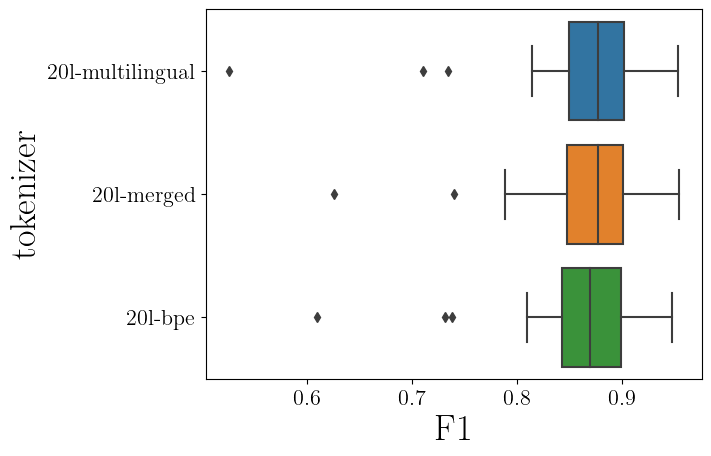

In [26]:
boxplot_across_languages(in_lang_results, 'F1', languages, task='NER')

# Correlation Analysis

In [27]:
in_lang_results

task     metric         tokenizer           ar           tr  \
0   allocation  Avg. Rank  20l-multilingual   998.499927  1542.169552   
1   allocation  Avg. Rank        20l-merged  1140.771154  1805.018004   
2   allocation  Avg. Rank           20l-bpe  1377.603127  1737.261238   
3           LM        MRR  20l-multilingual     0.480395     0.443326   
4           LM        MRR        20l-merged     0.382128     0.391262   
5           LM        MRR           20l-bpe     0.341168     0.360623   
6           LM        BPC  20l-multilingual     2.809116     3.162762   
7           LM        BPC        20l-merged     4.450555     3.671978   
8           LM        BPC           20l-bpe     4.210008     3.684293   
9          POS   accuracy  20l-multilingual     0.881480     0.819573   
10         POS   accuracy        20l-merged     0.884087     0.817837   
11         POS   accuracy           20l-bpe     0.882284     0.821536   
12         NER         F1  20l-multilingual     0.906988     0.916709   
13         NER         F1        20l-merged     0.905083     0.914687   
14         NER         F1           20l-bpe     0.901321     0.912621   

             zh           el           es           en           sw  ...  \
0   3032.913054  1022.523219   865.678179  1006.395642   688.218264  ...   
1   1632.205665   848.768601  1030.872451  1178.310573  1263.213479  ...   
2   1435.421560  1322.344354  1374.498583  1508.390232  1067.385033  ...   
3      0.429120     0.581047     0.569934     0.547350     0.599766  ...   
4      0.432430     0.534972     0.484906     0.481295     0.430163  ...   
5      0.297909     0.482371     0.443228     0.416950     0.469430  ...   
6      3.632192     1.979857     2.226074     2.676476     1.842017  ...   
7      3.314127     2.705757     3.153287     3.359716     3.387822  ...   
8      4.344548     2.689354     3.070970     3.199383     2.726139  ...   
9      0.902152     0.919399     0.957030     0.953684     0.000000  ...   
10     0.853758     0.900596     0.956023     0.954239     0.000000  ...   
11     0.771884     0.888716     0.957156     0.953609     0.000000  ...   
12     0.814587     0.890485     0.900186     0.847710     0.710180  ...   
13     0.788584     0.889543     0.899773     0.848099     0.819524  ...   
14     0.731507     0.883104     0.898173     0.843634     0.809444  ...   

             te           th           ru           bg           he  \
0    831.991246  1679.520468  1307.798790  1283.818858   977.710110   
1   1306.577003  1476.589936  1136.750083  1078.246633  1117.102173   
2    932.255922  1825.758262  1952.796223  1565.678702  1317.320375   
3      0.524826     0.410332     0.539339     0.505917     0.546358   
4      0.437704     0.407651     0.511561     0.473538     0.431616   
5      0.422270     0.344799     0.435141     0.414184     0.342054   
6      2.434927     4.014413     2.340380     2.882723     2.587668   
7      3.221119     4.032404     2.681147     3.369539     3.357312   
8      2.925789     4.052939     2.917984     3.429987     4.144439   
9      0.782247     0.000000     0.967681     0.984862     0.958612   
10     0.861304     0.000000     0.967183     0.983846     0.955824   
11     0.864078     0.000000     0.963943     0.982256     0.954553   
12     0.525546     0.734624     0.894741     0.915617     0.850384   
13     0.625977     0.740510     0.890514     0.916761     0.844764   
14     0.609891     0.738161     0.887805     0.911828     0.840417   

             ka          vi           fr           de  multilingual  
0   1007.787765  231.618779   859.951782  1086.955417  12458.673077  
1   1178.228674  747.978473  1019.059282  1129.858715  13784.345311  
2   1102.916002  858.687090  1377.207009  1530.965738  16176.282806  
3      0.496732    0.625554     0.573071     0.540647      0.526205  
4      0.442399    0.472117     0.497208     0.478364      0.447828  
5      0.413597    0.438418     0.442778     0.433308      0.405310

In [28]:
in_lang_stds

task     metric         tokenizer           ar           tr  \
0   allocation  Avg. Rank  20l-multilingual  1667.166681  2527.552090   
1   allocation  Avg. Rank        20l-merged  1882.782973  2653.586031   
2   allocation  Avg. Rank           20l-bpe  2018.529485  2524.094261   
3           LM        MRR  20l-multilingual     0.000000     0.000000   
4           LM        MRR        20l-merged     0.000000     0.000000   
5           LM        MRR           20l-bpe     0.000000     0.000000   
6           LM        BPC  20l-multilingual     0.000000     0.000000   
7           LM        BPC        20l-merged     0.000000     0.000000   
8           LM        BPC           20l-bpe     0.000000     0.000000   
9          POS   accuracy  20l-multilingual     0.000000     0.000000   
10         POS   accuracy        20l-merged     0.000000     0.000000   
11         POS   accuracy           20l-bpe     0.000000     0.000000   
12         NER         F1  20l-multilingual     0.000000     0.000000   
13         NER         F1        20l-merged     0.000000     0.000000   
14         NER         F1           20l-bpe     0.000000     0.000000   

             zh           el           es           en           sw  ...  \
0   4841.391720  1924.037149  1855.175126  2270.220247  1403.781022  ...   
1   2408.692084  1557.712389  1901.979929  2133.139005  2094.614573  ...   
2   2458.814662  2138.067500  2384.066940  2804.831095  1691.346037  ...   
3      0.000000     0.000000     0.000000     0.000000     0.000000  ...   
4      0.000000     0.000000     0.000000     0.000000     0.000000  ...   
5      0.000000     0.000000     0.000000     0.000000     0.000000  ...   
6      0.000000     0.000000     0.000000     0.000000     0.000000  ...   
7      0.000000     0.000000     0.000000     0.000000     0.000000  ...   
8      0.000000     0.000000     0.000000     0.000000     0.000000  ...   
9      0.000000     0.000000     0.000000     0.000000     0.000000  ...   
10     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
11     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
12     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
13     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
14     0.000000     0.000000     0.000000     0.000000     0.000000  ...   

             te           th           ru           bg           he  \
0   1374.335220  2795.650568  2504.984832  2525.790911  1746.445075   
1   2073.198315  2265.966073  1976.280552  2004.510863  1887.457335   
2   1412.717259  2620.753325  3009.851559  2642.349316  2029.726396   
3      0.000000     0.000000     0.000000     0.000000     0.000000   
4      0.000000     0.000000     0.000000     0.000000     0.000000   
5      0.000000     0.000000     0.000000     0.000000     0.000000   
6      0.000000     0.000000     0.000000     0.000000     0.000000   
7      0.000000     0.000000     0.000000     0.000000     0.000000   
8      0.000000     0.000000     0.000000     0.000000     0.000000   
9      0.000000     0.000000     0.000000     0.000000     0.000000   
10     0.000000     0.000000     0.000000     0.000000     0.000000   
11     0.000000     0.000000     0.000000     0.000000     0.000000   
12     0.000000     0.000000     0.000000     0.000000     0.000000   
13     0.000000     0.000000     0.000000     0.000000     0.000000   
14     0.000000     0.000000     0.000000     0.000000     0.000000   

             ka           vi           fr           de  multilingual  
0   1878.782818   708.308194  1907.704961  2285.714831  22258.966907  
1   2027.128878  1318.327918  1893.399453  2006.038186  23210.890042  
2   1818.351281  1532.506251  2428.945402  2579.632063  25377.768811  
3      0.000000     0.000000     0.000000     0.000000      0.000000  
4      0.000000     0.000000     0.000000     0.000000      0.000000  
5      0.000000     0.000000     0.000000     0.000000      0

## Pairwaise factor analysis

In [29]:
in_lang_ca = pd.melt(in_lang_results, id_vars=['task', 'metric', 'tokenizer'],
                     value_vars=languages, var_name='language').\
                    pivot_table(columns=['task', 'metric'], values='value', index=['language', 'tokenizer']).\
                    reset_index()

in_lang_ca.columns = ["_".join(pair) for pair in in_lang_ca.columns]

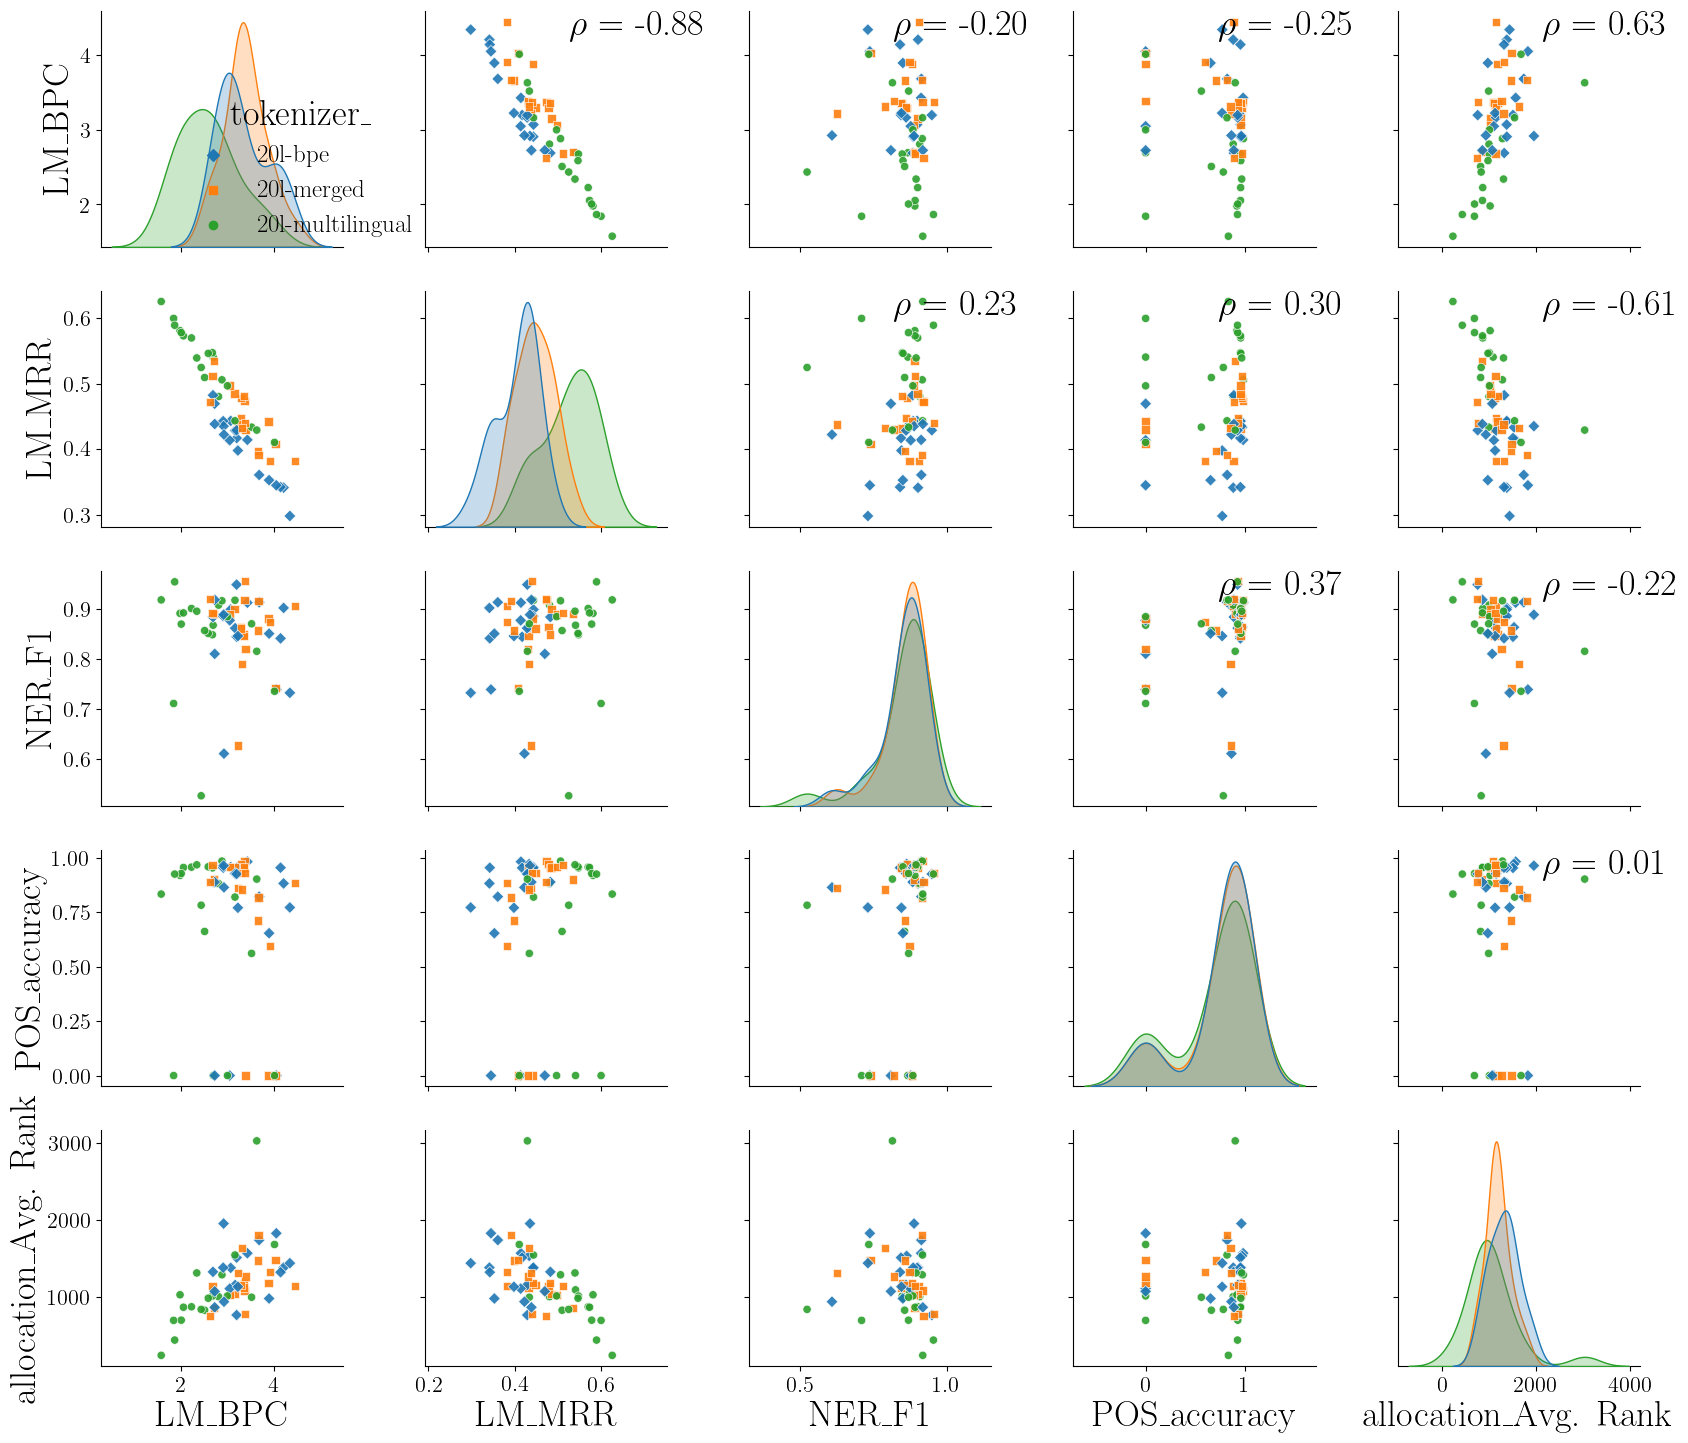

In [30]:
spearman_r = in_lang_ca.corr(method='spearman').to_numpy()
spearman_p = in_lang_ca.corr(method=lambda x, y: spearmanr(x, y)[1]).to_numpy()

#plt.figure(figsize=(3.5,3.5))
plot1 = sns.pairplot(in_lang_ca, hue="tokenizer_",
                     markers=['D','s', 'o', 'p', 'X'],
                     plot_kws={'alpha': 0.9},
                    size=3)

plot1._legend.set_bbox_to_anchor((.25, 0.85))
# plt.legend(loc='center right', title='Type')
plot1.map
axes = plot1.axes
for i in range(4):
    for j in range(i+1,5):
        ax = axes[i][j]
        r = spearman_r[i,j]
        p = spearman_p[i,j]
        ax.annotate(r"$\rho$ = {:.2f}".format(r), xy=(.6, .9), xycoords=ax.transAxes)
#         ax.annotate(r"$p$ = {:.4f}".format(p), xy=(.7, .8), xycoords=ax.transAxes)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "pair_analysis_20L.pdf"), dpi=300)


In [31]:
spearman_r

array([[ 1.        , -0.8811806 , -0.20292227, -0.24747051,  0.63045003],
       [-0.8811806 ,  1.        ,  0.23061962,  0.29698609, -0.61116977],
       [-0.20292227,  0.23061962,  1.        ,  0.37320992, -0.22022784],
       [-0.24747051,  0.29698609,  0.37320992,  1.        ,  0.00540279],
       [ 0.63045003, -0.61116977, -0.22022784,  0.00540279,  1.        ]])

In [32]:
spearman_p

array([[1.00000000e+00, 3.39232416e-20, 1.23216657e-01, 5.87987624e-02,
        8.73687607e-08],
       [3.39232416e-20, 1.00000000e+00, 7.62659329e-02, 2.12052718e-02,
        2.14248301e-07],
       [1.23216657e-01, 7.62659329e-02, 1.00000000e+00, 3.31428110e-03,
        9.08709853e-02],
       [5.87987624e-02, 2.12052718e-02, 3.31428110e-03, 1.00000000e+00,
        9.67320034e-01],
       [8.73687607e-08, 2.14248301e-07, 9.08709853e-02, 9.67320034e-01,
        1.00000000e+00]])